# Importing required libraries

In [18]:
import os
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.applications import EfficientNetB0, VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from IPython.display import display, Markdown

# Importing the dataset

##### The dataset has 2 files: `train.csv` and `valid.csv` with a proportion of 70:30 images and a total of 10k images.

**Real:** NVIDIA Research's Flickr-Faces-HQ Dataset. Represented as 1 in dataset.  
**Fake:** Bojan Tunguz's 1 Million Fake Face dataset generated by StyleGAN. Represented as 0 in dataset


In [19]:
train_file_path = os.path.join(os.getcwd(), '..', 'Data', 'train.csv')
valid_file_path = os.path.join(os.getcwd(), '..', 'Data', 'valid.csv')

train_df = pd.read_csv(train_file_path)
valid_df = pd.read_csv(valid_file_path)

In [5]:
pd.concat([train_df.sample(2).assign(Source='train_df'), 
           valid_df.sample(2).assign(Source='valid_df')])

,Unnamed: 0,original_path,id,label,label_str,path,Source
3339,12275,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,08957,1,real,train/real/08957.jpg,train_df
6508,18711,/kaggle/input/1-million-fake-faces/1m_faces_08...,T5SS3DFPB6,0,fake,train/fake/T5SS3DFPB6.jpg,train_df
2314,15628,/kaggle/input/1-million-fake-faces/1m_faces_08...,VY0DF8995J,0,fake,valid/fake/VY0DF8995J.jpg,valid_df
1584,44487,/kaggle/input/1-million-fake-faces/1m_faces_04...,F8CR5RMRIT,0,fake,valid/fake/F8CR5RMRIT.jpg,valid_df


#### Updating images path to absolute path from relative for modelling

**From:** train/real/04727.jpg  \
**To:** D:\Git\DeepGuard\Notebooks\\..\Data\train\real\04727.jpg



In [20]:
base_images_path = os.path.join(os.getcwd(), '..', 'Data')

## Replacing '/' in the dataframe with '\'
train_df['path'] = train_df['path'].str.replace('/', '\\')
valid_df['path'] = valid_df['path'].str.replace('/', '\\')

## Adding getcwd() path to dataframe
train_df['path'] = train_df['path'].apply(lambda path: os.path.join(base_images_path, path))
valid_df['path'] = valid_df['path'].apply(lambda path: os.path.join(base_images_path, path))

#### Removing unwanted columns

In [21]:
drop_columns = ['Unnamed: 0', 'original_path', 'id']
train_df.drop(columns=drop_columns, inplace=True)
valid_df.drop(columns=drop_columns, inplace=True)

#### Sampling 3 images from each training and validation

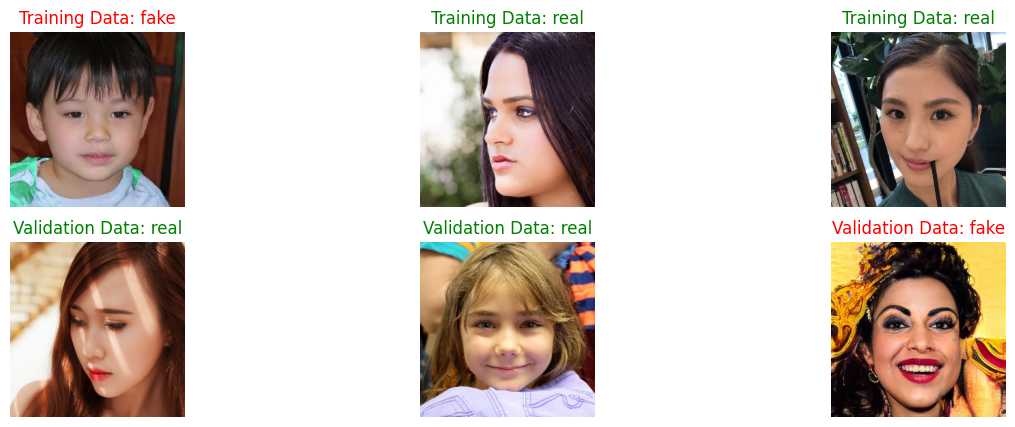

In [22]:
fig, axes = plt.subplots(2, 3, figsize=(15, 5))
sample_images = pd.concat([train_df.sample(3).assign(Source='Training Data'), valid_df.sample(3).assign(Source='Validation Data')])

for ax, (_, row) in zip(axes.flatten(), sample_images.iterrows()):
    path = row['path']
    label = row['label_str']
    title = row['Source'] + ': ' + label
    
    image = Image.open(path)
    ax.imshow(image)
    ax.axis('off')
    ax.set_title(title, fontsize=12, color='green' if label=='real' else 'red')

# Train Test Split with (Train, Validation, Test = 70,10,20)
Using train_df for training and valid_df for validation and test.

**Train_df (70%)**  
 - Training(100%) - 7k images
 
**Valid_df (30%)**: Perform 67-33 split for test and validation
 - Test(67%) - 2k images
 - Validation(33%) - 1k images  

In [23]:
# Initial Dataset
display(Markdown('**Initial Counts before Split**'))
display(pd.concat([train_df['label_str'].value_counts(), valid_df['label_str'].value_counts()], axis=1, keys=['Train', 'Validation']))

#Splitting valid_df into validation and test dataset in 10-20 proportion of total data
validation_df, test_df = train_test_split(valid_df, test_size=0.67, random_state=1000)
display(Markdown('**After Test-Validation Split**'))
display(pd.concat([train_df['label_str'].value_counts(), validation_df['label_str'].value_counts(), test_df['label_str'].value_counts()], axis=1, 
                  keys=['Train', 'Validation', 'Test']))

**Initial Counts before Split**

,Train,Validation
real,3500,1500
fake,3500,1500


**After Test-Validation Split**

,Train,Validation,Test
real,3500,493,1007
fake,3500,496,1004


In [ ]:
# # Train, Val and Test Dataset 
# X_train = train_df['path'].values
# y_train = train_df['label'].values

# X_val = validation_df['path'].values
# y_val = validation_df['label'].values

# X_test = test_df['path'].values
# y_test = test_df['label'].values

## Preprocess - Resize (224*224) & Normalize Pixel Values [0,1]

Occupies too much memory so using ImageDataGenerator to perform these steps during training

In [ ]:
# def preprocess_image(image_path, image_size= (224,224)):
#     # Load + Resize
#     img = tf.keras.preprocessing.image.load_img(image_path, target_size=image_size)
#     # image to array
#     img_array = tf.keras.preprocessing.image.img_to_array(img)
#     # Normalization
#     img_array = img_array / 255.0
#     return img_array

# # preprocess_image(train_df['path'][0], image_size).shape
# image_size = (224,224)

# X_train_processed = [preprocess_image(image_path, image_size) for image_path in X_train]
# X_val_processed = [preprocess_image(image_path, image_size) for image_path in X_val]
# X_test_processed = [preprocess_image(image_path, image_size) for image_path in X_test]

## Augmentation

In [24]:
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,    # Normalizing pixel values [0,1]
    rotation_range=50,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

valid_test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,    # Normalizing pixel values [0,1]
)

In [25]:
image_size = (224, 224)
batch_size=32

train_augmented_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='path',
    y_col='label_str',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary'
)

valid_augmented_generator = valid_test_datagen.flow_from_dataframe(
    dataframe=validation_df,
    x_col='path',
    y_col='label_str',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary'
)

test_augmented_generator = valid_test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='path',
    y_col='label_str',
    target_size=image_size, 
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False  # Do not shuffle test data
)

Found 7000 validated image filenames belonging to 2 classes.
Found 989 validated image filenames belonging to 2 classes.
Found 2011 validated image filenames belonging to 2 classes.


## Define Model Architecture

#### Model 1

In [14]:
model1 = Sequential([                                                  # 224x224x3
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),  # 222x222x32
    MaxPooling2D(pool_size=(2, 2)),                                    # 111x111x32 
    
    Conv2D(64, (3, 3), activation='relu'),                             # 109x109x64
    MaxPooling2D(pool_size=(2, 2)),                                    # 54x54x64

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    
    Flatten(),                                                         
    Dense(256, activation='relu'),                                     
    Dropout(0.5),                                                      
    Dense(1, activation='sigmoid')                                     
])
model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 128)      0

#### Model 2 - Using Batch Normalization

In [128]:
model2 = Sequential([                                                  # 224x224x3
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),  # 222x222x32
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),                                    # 111x111x32 
    
    Conv2D(64, (3, 3), activation='relu'),                             # 109x109x64
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),                                    # 54x54x64

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    
    Flatten(),                                                         
    Dense(256, activation='relu'),                                     
    Dropout(0.5),                                                      
    Dense(1, activation='sigmoid')                                     
])
model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
model2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 batch_normalization_12 (Bat  (None, 222, 222, 32)     128       
 chNormalization)                                                
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 111, 111, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 109, 109, 64)      18496     
                                                                 
 batch_normalization_13 (Bat  (None, 109, 109, 64)     256       
 chNormalization)                                                
                                                      

#### Model 3 - Adding more layers

In [112]:
model3 = Sequential([                                                  
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),  
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),                                    

    Conv2D(32, (3, 3), activation='relu'),                             
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)), 
    
    Conv2D(64, (3, 3), activation='relu'),                             
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),                                    

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    
    Flatten(),                                                         
    Dense(256, activation='relu'),                                     
    Dropout(0.5),                                                      
    Dense(1, activation='sigmoid')                                     
])
model3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
model3.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_11 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 batch_normalization_8 (Batc  (None, 222, 222, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 111, 111, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 109, 109, 32)      9248      
                                                                 
 batch_normalization_9 (Batc  (None, 109, 109, 32)     128       
 hNormalization)                                                 
                                                      

## Training models

In [113]:
def train_gen (model, train_generator, valid_generator, epochs, batch_size):
    history = model.fit(
        train_generator,
        steps_per_epoch=len(train_generator),
        epochs=epochs,
        validation_data=valid_generator,
        validation_steps=len(valid_generator),
        batch_size=batch_size
    )

    return history

#### Training Model 1

In [126]:
model1.load_weights('model1_75.h5')

In [153]:
batch_size = 32
epochs=2

# history1 = train_gen(model1, train_augmented_generator, valid_augmented_generator, 10, 32)
history1 = model1.fit(
    train_augmented_generator,
    steps_per_epoch=len(train_augmented_generator),
    epochs=epochs,
    validation_data=valid_augmented_generator,
    validation_steps=len(valid_augmented_generator),
    batch_size=batch_size
)

Epoch 1/2
219/219 [==============================] - 113s 515ms/step - loss: 0.5040 - accuracy: 0.7626 - val_loss: 0.4993 - val_accuracy: 0.7513
Epoch 2/2
219/219 [==============================] - 110s 502ms/step - loss: 0.5004 - accuracy: 0.7554 - val_loss: 0.5474 - val_accuracy: 0.7230


In [ ]:
model1.save_weights('model1_75.h5')

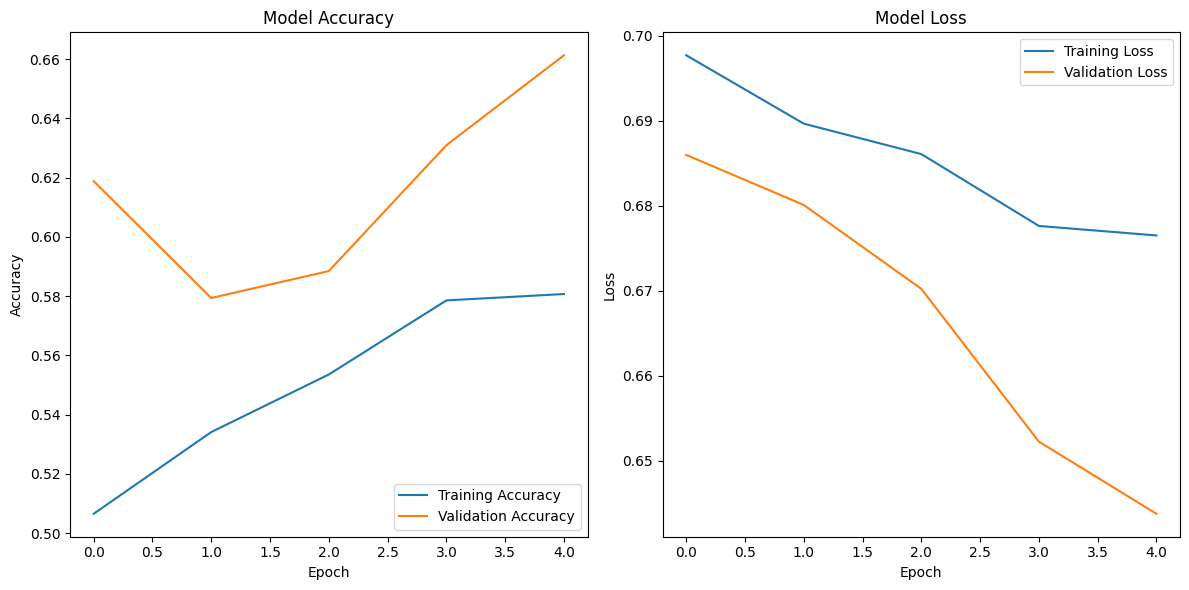

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot training & validation accuracy values
axs[0].plot(history1.history['accuracy'], label='Training Accuracy')
axs[0].plot(history1.history['val_accuracy'], label='Validation Accuracy')
axs[0].set_title('Model Accuracy')
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].legend(loc='lower right')

# Plot training & validation loss values
axs[1].plot(history1.history['loss'], label='Training Loss')
axs[1].plot(history1.history['val_loss'], label='Validation Loss')
axs[1].set_title('Model Loss')
axs[1].set_ylabel('Loss')
axs[1].set_xlabel('Epoch')
axs[1].legend(loc='upper right')

# Adjust layout
plt.tight_layout()
plt.show()


#### Training Model 2

In [129]:
model2.load_weights('model2_50.h5')

In [155]:
batch_size = 32
epochs=2

# history2 = train_gen(model2, train_augmented_generator, valid_augmented_generator, 10, 32)
history2 = model2.fit(
    train_augmented_generator,
    steps_per_epoch=len(train_augmented_generator),
    epochs=epochs,
    validation_data=valid_augmented_generator,
    validation_steps=len(valid_augmented_generator),
    batch_size=batch_size
)

Epoch 1/2
219/219 [==============================] - 120s 545ms/step - loss: 0.5453 - accuracy: 0.7286 - val_loss: 0.4943 - val_accuracy: 0.7674
Epoch 2/2
219/219 [==============================] - 123s 561ms/step - loss: 0.5361 - accuracy: 0.7371 - val_loss: 0.5598 - val_accuracy: 0.7260


In [ ]:
model2.save_weights('model2_50.h5')

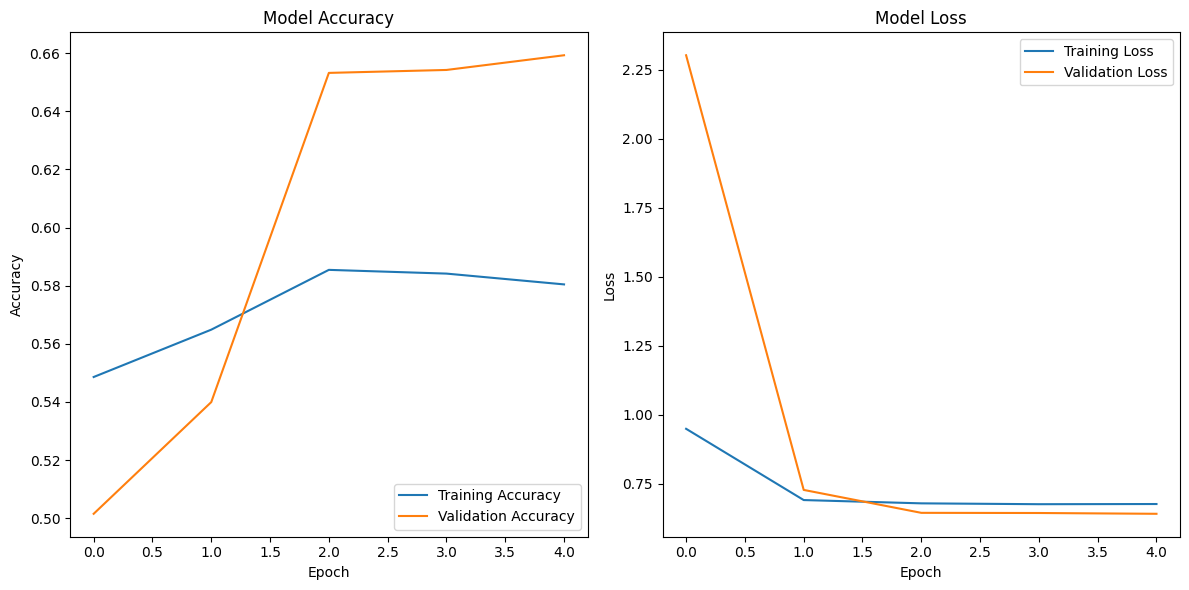

In [17]:
history = history2
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot training & validation accuracy values
axs[0].plot(history.history['accuracy'], label='Training Accuracy')
axs[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
axs[0].set_title('Model Accuracy')
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].legend(loc='lower right')

# Plot training & validation loss values
axs[1].plot(history.history['loss'], label='Training Loss')
axs[1].plot(history.history['val_loss'], label='Validation Loss')
axs[1].set_title('Model Loss')
axs[1].set_ylabel('Loss')
axs[1].set_xlabel('Epoch')
axs[1].legend(loc='upper right')

# Adjust layout
plt.tight_layout()
plt.show()

#### Training Model 3

In [125]:
model3.load_weights('model3_145_85.h5')

In [123]:
batch_size = 32
epochs=5

history3 = model3.fit(
    train_augmented_generator,
    steps_per_epoch=len(train_augmented_generator),
    epochs=epochs,
    validation_data=valid_augmented_generator,
    validation_steps=len(valid_augmented_generator),
    batch_size=batch_size
)

Epoch 1/5
219/219 [==============================] - 56s 255ms/step - loss: 0.2459 - accuracy: 0.9017 - val_loss: 0.5042 - val_accuracy: 0.8099
Epoch 2/5
219/219 [==============================] - 56s 258ms/step - loss: 0.2523 - accuracy: 0.8954 - val_loss: 0.4395 - val_accuracy: 0.8413
Epoch 3/5
219/219 [==============================] - 55s 253ms/step - loss: 0.2538 - accuracy: 0.8969 - val_loss: 0.4190 - val_accuracy: 0.8443
Epoch 4/5
219/219 [==============================] - 56s 254ms/step - loss: 0.2555 - accuracy: 0.8914 - val_loss: 0.3573 - val_accuracy: 0.8635
Epoch 5/5
219/219 [==============================] - 56s 254ms/step - loss: 0.2599 - accuracy: 0.8914 - val_loss: 0.4054 - val_accuracy: 0.8352


In [122]:
model3.save_weights('model3_150_85.h5')

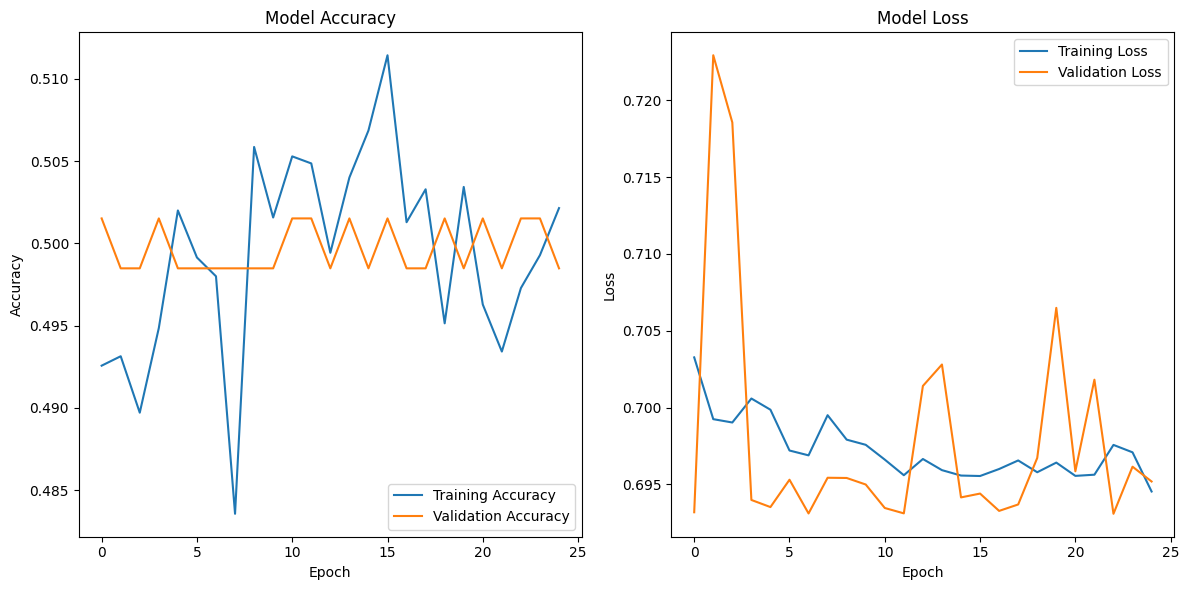

In [32]:
history = history3
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot training & validation accuracy values
axs[0].plot(history.history['accuracy'], label='Training Accuracy')
axs[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
axs[0].set_title('Model Accuracy')
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].legend(loc='lower right')

# Plot training & validation loss values
axs[1].plot(history.history['loss'], label='Training Loss')
axs[1].plot(history.history['val_loss'], label='Validation Loss')
axs[1].set_title('Model Loss')
axs[1].set_ylabel('Loss')
axs[1].set_xlabel('Epoch')
axs[1].legend(loc='upper right')

# Adjust layout
plt.tight_layout()
plt.show()


## Test

In [130]:
def test_evaluate_gen (model, test_generator):
    loss, accuracy = model.evaluate(test_augmented_generator, steps=len(test_augmented_generator))
    return loss, accuracy

def test_predictions_gen (model, test_generator):
    y_pred = model.predict(test_augmented_generator)
    y_pred = np.round(y_pred).astype(int)
    return y_pred
    
def test_labels (test_df):
    y_test = test_df['label'].values
    return y_test

def get_y_test_pred (model, test_generator, test_df):
    y_pred = test_predictions_gen (model, test_generator)
    y_test = test_labels (test_df)
    return y_pred, y_test

def conf_mat(y_pred, y_test):    
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    plt.imshow(conf_matrix, cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.xticks([0, 1], ['Real', 'Fake'])
    plt.yticks([0, 1], ['Real', 'Fake'])
    for i in range(2):
        for j in range(2):
            plt.text(j, i, conf_matrix[i, j], ha='center', va='center', color='red')
    plt.show()

    # print("Confusion Matrix:")
    # print(conf_matrix)

def roc(y_pred, y_test):    
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

##### Predicting labels

In [131]:
y_test = test_labels (test_df)

In [132]:
y_pred1 = test_predictions_gen(model1, test_augmented_generator)

63/63 [==============================] - 3s 43ms/step


In [134]:
y_pred2 = test_predictions_gen(model2, test_augmented_generator)

63/63 [==============================] - 3s 42ms/step


In [136]:
y_pred3 = test_predictions_gen(model3, test_augmented_generator)

63/63 [==============================] - 3s 42ms/step


##### Accuracy

In [149]:
loss, accuracy = test_evaluate_gen(model1, test_augmented_generator)
print("Test Accuracy:", accuracy)

63/63 [==============================] - 6s 94ms/step - loss: 0.6433 - accuracy: 0.6788
Test Accuracy: 0.6787667870521545


In [150]:
loss, accuracy = test_evaluate_gen(model2, test_augmented_generator)
print("Test Accuracy:", accuracy)

63/63 [==============================] - 7s 109ms/step - loss: 0.6269 - accuracy: 0.6847
Test Accuracy: 0.6847339868545532


In [151]:
loss, accuracy = test_evaluate_gen(model3, test_augmented_generator)
print("Test Accuracy:", accuracy)

63/63 [==============================] - 6s 91ms/step - loss: 0.3734 - accuracy: 0.8523
Test Accuracy: 0.8523122668266296


##### Confusion Matrix

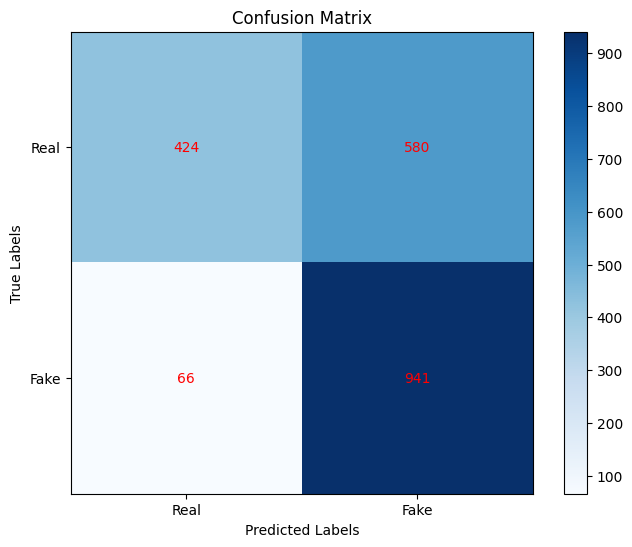

In [141]:
conf_mat(y_pred1, y_test)

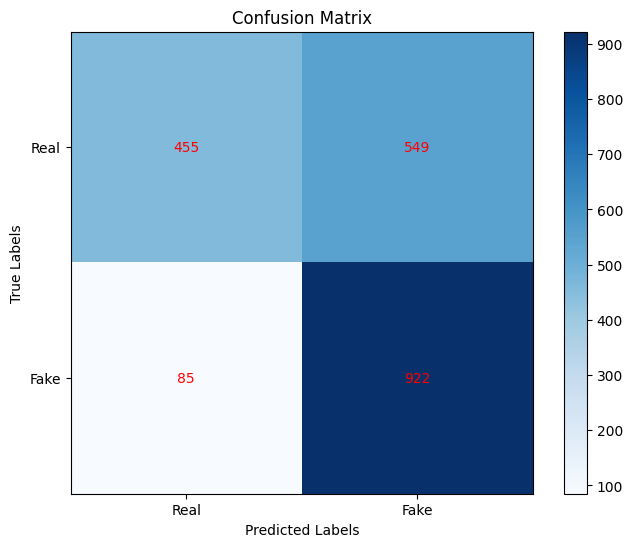

In [142]:
conf_mat(y_pred2, y_test)

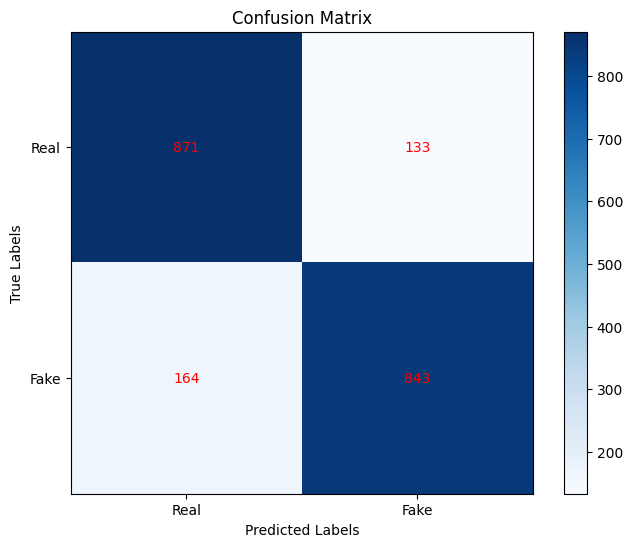

In [143]:
conf_mat(y_pred3, y_test)

##### ROC Curve

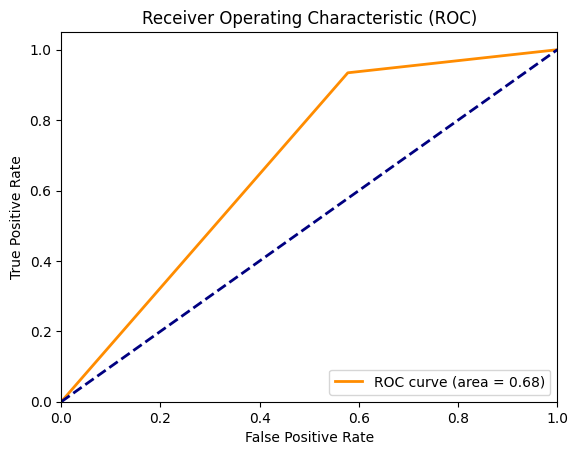

In [144]:
roc(y_pred1, y_test)

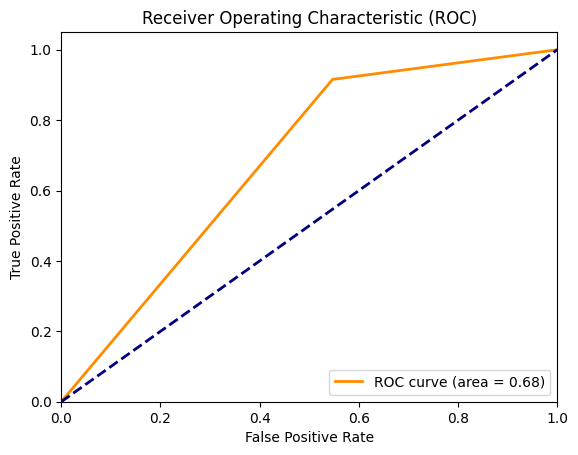

In [145]:
roc(y_pred2, y_test)

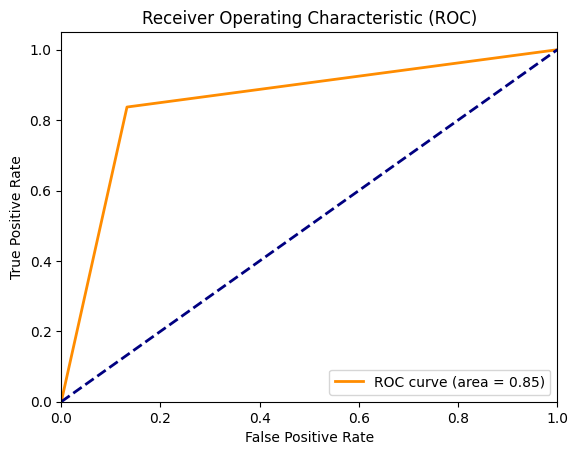

In [146]:
roc(y_pred3, y_test)

In [147]:
import tensorflow as tf

# Print TensorFlow version
print("TensorFlow version:", tf.__version__)

# Check if GPU is available
if tf.config.list_physical_devices('GPU'):
    print("GPU is available.")
else:
    print("GPU is not available.")

# Check if cuDNN is enabled
if tf.test.is_built_with_cuda():
    print("cuDNN is enabled.")
else:
    print("cuDNN is not enabled.")

TensorFlow version: 2.10.0
GPU is available.
cuDNN is enabled.
